# ROCA
---
_**R**ank **O**rder **C**lustering **A**lgorithm_

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
def plot_table(df, figsize=(12, 6), margin=8):
    fig, ax = plt.subplots(figsize=figsize)
    # hide axes
    fig.patch.set_visible(False)
    ax.axis("off")
    ax.axis("tight")
    # plot table
    m = " "*margin
    ax.table(
        cellText=df.values,
        rowLabels=[f'{m}{i}{m}' for i in df.index],
        colLabels=df.columns,
        cellColours=np.where(
            df.values,
            "#00ff88",
            "#ff0044"
        ),
        bbox=[0, 0, 1, 1],
        loc="center",
        cellLoc="center"
    )
    # output
    fig.tight_layout()
    plt.show()

## 1. Introduction
---
The **ROCA** (_Rank Order Clustering Algorithm_) method is a technique used to group elements into clusters based on their similarities through dichotomous features. This method was initially designed for [Production Flow Analysis](https://en.wikipedia.org/wiki/Production_flow_analysis), to solve factory layout and production optimization problems. It is especially useful wherever it is necessary to group machines, products or tasks efficiently.

### 1.1. Applications
---
The _ROCA method_ can be used in any situation where it is necessary to group elements based on binary characteristics. Some examples are:

- Manufacturing cells
- Equipment layout
- Element gathering

For example, let's consider a set of _Manufacturing Equipment_ $M$ that each produces different _Products_ $P$:

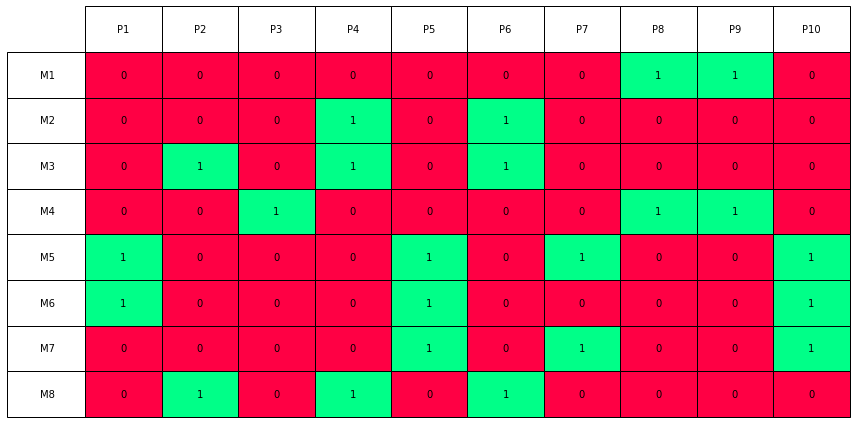

In [5]:
data = np.array([
    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
])

n, m = data.shape
M = np.arange(m)
N = np.arange(n)
np.random.seed(42)
np.random.shuffle(M)
np.random.shuffle(N)

df = pd.DataFrame(data[N][:,M])
df.index = [f'M{i}' for i in np.arange(n)+1]
df.columns = [f'P{j}' for j in np.arange(m)+1]

plot_table(df)

## 2. Method steps
---

In [6]:
df_ = df.copy()

### 2.1. Decimal of rows
---
For each row, calculate the decimal representation of the binary sequence:

$$ \large
d_i = \sum_{j=1}^m b_{ij} \cdot 2^{m-j}
$$

In [7]:
cols = df_.columns
m = len(cols)

M_bin = pd.Series([2**(m - j) for j in np.arange(m)+1], index=cols)
M_dec = np.sum(df_*M_bin, axis=1)

M_dec

M1      6
M2     80
M3    336
M4    134
M5    553
M6    545
M7     41
M8    336
dtype: int64

### 2.2. Order rows
---
Order rows based on descending sort of decimal values, previously computed.

In [8]:
df_ = df_.iloc[np.argsort(-M_dec)]

df_

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10
M5,1,0,0,0,1,0,1,0,0,1
M6,1,0,0,0,1,0,0,0,0,1
M3,0,1,0,1,0,1,0,0,0,0
M8,0,1,0,1,0,1,0,0,0,0
M4,0,0,1,0,0,0,0,1,1,0
M2,0,0,0,1,0,1,0,0,0,0
M7,0,0,0,0,1,0,1,0,0,1
M1,0,0,0,0,0,0,0,1,1,0


### 2.3. Decimal of columns
---
For each column, calculate the decimal representation of the binary sequence:

$$ \large
d_j = \sum_{i=1}^n b_{ij} \cdot 2^{n-i}
$$

In [9]:
rows = df_.index
n = len(rows)

N_bin = pd.Series([2**(n - i) for i in np.arange(n)+1], index=rows)
N_dec = np.sum(df_.T*N_bin, axis=1)

N_dec

P1     192
P2      48
P3       8
P4      52
P5     194
P6      52
P7     130
P8       9
P9       9
P10    194
dtype: int64

### 2.4. Order columns
---
Order columns based on descending sort of decimal values, previously computed.

In [10]:
df_ = df_.iloc[:, np.argsort(-N_dec)]

df_

,P5,P10,P1,P7,P4,P6,P2,P8,P9,P3
M5,1,1,1,1,0,0,0,0,0,0
M6,1,1,1,0,0,0,0,0,0,0
M3,0,0,0,0,1,1,1,0,0,0
M8,0,0,0,0,1,1,1,0,0,0
M4,0,0,0,0,0,0,0,1,1,1
M2,0,0,0,0,1,1,0,0,0,0
M7,1,1,0,1,0,0,0,0,0,0
M1,0,0,0,0,0,0,0,1,1,0


### 2.5. Repeat
---
Repeat the steps 1 to 4 until the matrix does not change.

In [11]:
def order_rows(df):
    # Calculate decimals
    cols = df.columns
    m = len(cols)
    M_bin = pd.Series([2**(m - j) for j in np.arange(m)+1], index=cols)
    M_dec = np.sum(df*M_bin, axis=1)
    # Order rows
    df = df.iloc[np.argsort(-M_dec)]
    return df

def order_columns(df):
    # Calculate decimals
    rows = df.index
    n = len(rows)
    N_bin = pd.Series([2**(n - i) for i in np.arange(n)+1], index=rows)
    N_dec = np.sum(df.T*N_bin, axis=1)
    # Order columns
    df = df.iloc[:, np.argsort(-N_dec)]
    return df

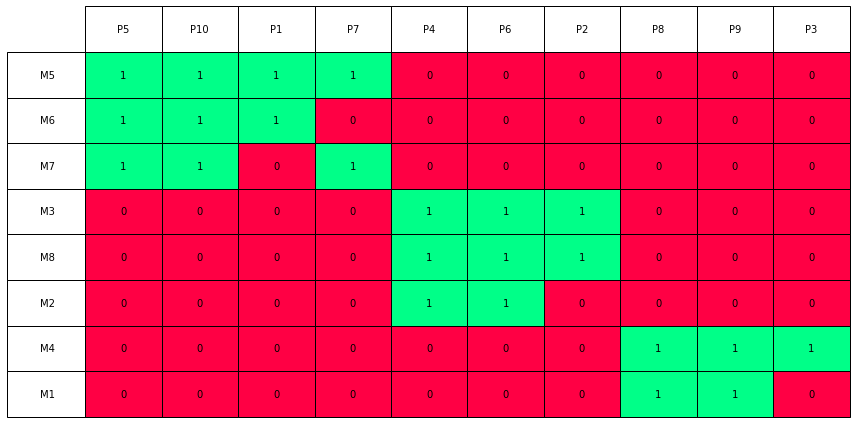

In [12]:
df_a = df.copy()
df_b = df.copy()
df_b[:] = 0

while not np.array_equal(np.array(df_a), np.array(df_b)):
    df_b = df_a.copy()
    df_a = order_rows(df_a)
    df_a = order_columns(df_a)

plot_table(df_a)

## 3. Examples
---

### 3.1. Gym equipment layout
---
As an example, let's organize **exercise or equipment** so that we gather it by **muscle groups**. The data was taken from a fitness app I have here in my phone and the mains idea was to select activities from a traditional gym.

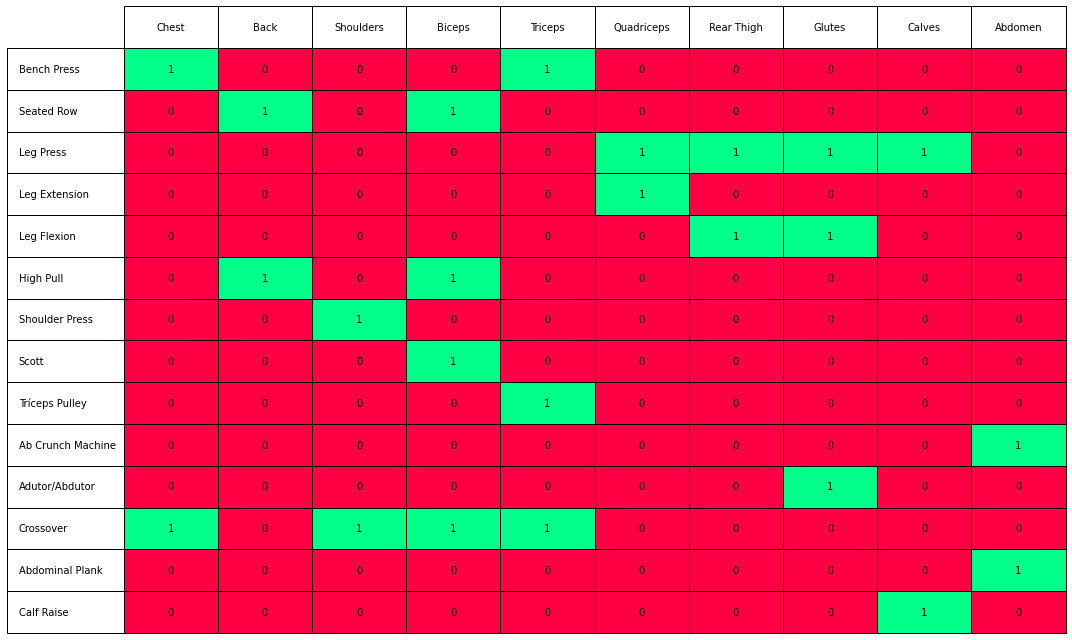

In [13]:
data = [
    [1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
    [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [1, 0, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
]

df_ex1 = pd.DataFrame(data)

df_ex1.index = [
    "Bench Press", "Seated Row", "Leg Press", 
    "Leg Extension", "Leg Flexion", 
    "High Pull", "Shoulder Press", "Scott",
    "Tríceps Pulley", 
    "Ab Crunch Machine", "Adutor/Abdutor", 
    "Crossover", "Abdominal Plank", 
    "Calf Raise"
]

df_ex1.columns = [
    "Chest", "Back", "Shoulders", "Biceps",
    "Triceps", "Quadriceps", "Rear Thigh", 
    "Glutes", "Calves", "Abdomen"
]



plot_table(df_ex1, (15, 9), 0)

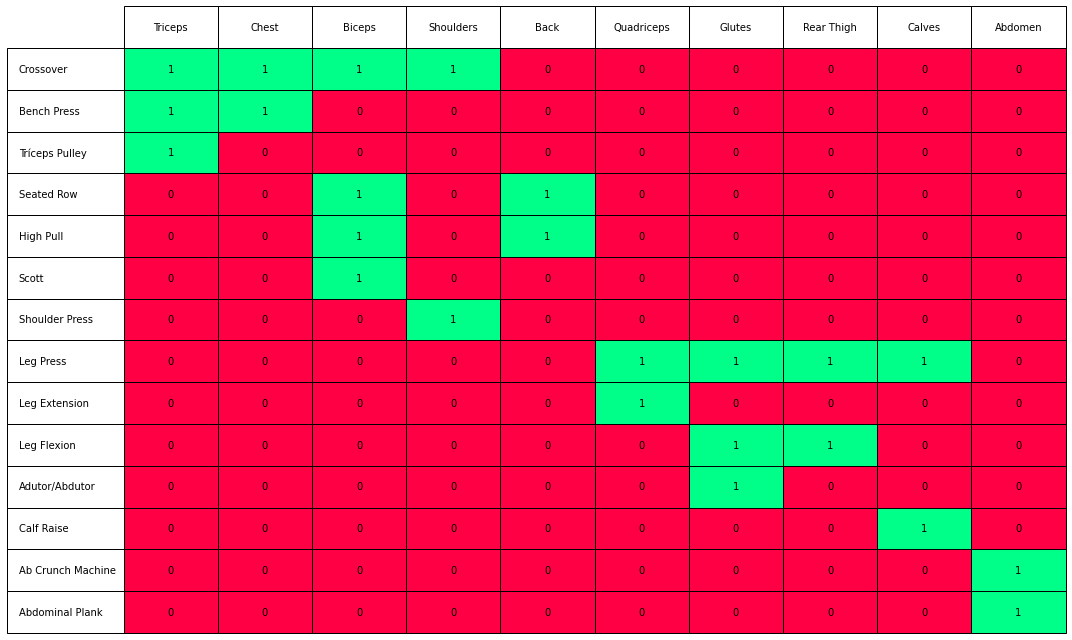

In [14]:
df_ex1_a = df_ex1.copy()
df_ex1_b = df_ex1.copy()
df_ex1_b[:] = 0

while not np.array_equal(np.array(df_ex1_a), np.array(df_ex1_b)):
    df_ex1_b = df_ex1_a.copy()
    df_ex1_a = order_rows(df_ex1_a)
    df_ex1_a = order_columns(df_ex1_a)

plot_table(df_ex1_a, (15, 9), 0)